In [1]:
import numpy as np
import torch
from torch import nn
import networkx as nx
import copy

In [2]:
# Get cpu or gpu device for training.
# device = "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Using {device} device")

Using cpu device


# Generate Input Data for a Simple Circuit
Circuit is an independent voltage source and a resistor.

MultiDiGraph with 2 nodes and 2 edges
(0, {'type': 'n', 'v': 0})
(1, {'type': 'n', 'v': ''})
(0, 1, {'type': 's', 'v': '', 'i': 1, 'p': ''})
(1, 0, {'type': 'r', 'v': '', 'i': '', 'p': 1})


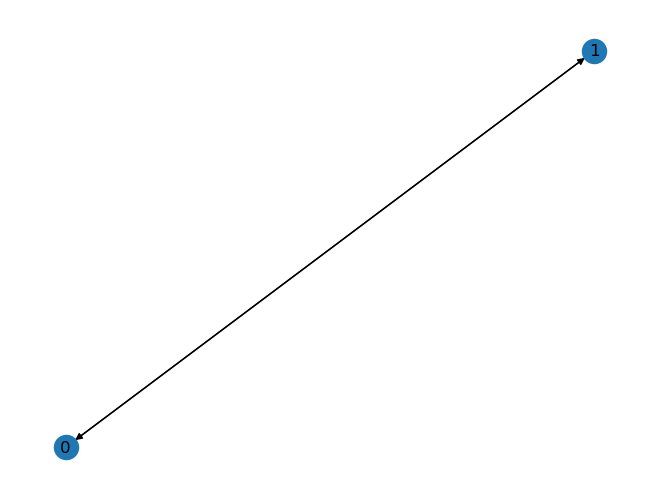

In [3]:
vr = nx.MultiDiGraph()
vr.add_node(0,type='n',v=0)
vr.add_node(1,type='n',v='')
# tail of edge is starting node
# head of edge is ending node
vr.add_edges_from(
        [
            (0,1,{'type':'s','v':'','i':1,'p':''}),
            (1,0,{'type':'r','v':'','i':'','p':1}),
        ]
    )
print(vr)
for node in vr.nodes().data():
    print(node)
for edge in vr.edges.data():
    print(edge)
nx.draw(vr,with_labels = True)

# Expected Sizes of Vectors

In [4]:
# create tensors for voltages, currents, and element attrs
num_elements = vr.number_of_edges()
num_nodes = vr.number_of_nodes()
print(f'size of element currents, voltages, and attr = ({num_elements},1)')
print(f'size of node voltages = ({num_nodes},1)')

size of element currents, voltages, and attr = (2,1)
size of node voltages = (2,1)


# Extract Circuit inputs for the Model

In [5]:
def extract(nx_list: list, attr_order_map: dict, types_map: dict):
    '''
    input: node or edge list with data from nx graph. Key order is a list of maps 
    from the attr key to the desired order in the ouput vectors [{str:int}]

    output:  two matrices. 
                attr matrix rows are each edge/node of graph.  Columns are
                    each attr value corresponding to key order
                knowns matrix rows are each edge/node of graph.  Columns are 
                    boolean of if the attr value is known
    '''
    attr_matrix = []
    knowns_matrix = []
    type_matrix = []
    num_attr = len(next(iter(nx_list))[-1])-1
    num_types = len(types_map)
    print(f'len(key_order_map) = num_attr => {len(attr_order_map)}, {num_attr}' )
    assert(len(attr_order_map) == num_attr)
    for item in nx_list: # each edge or node
        last_element: dict = item[-1]
        type_oh = [0]*(num_types) # one-hot encoding
        values = [0]*num_attr
        knowns_oh = [0]*num_attr # one-hot encoding
        for attr,value in last_element.items():
            if(attr == 'type'):
                type_idx = types_map[value]
                type_oh[type_idx] = 1
                continue
            
            idx = attr_order_map[attr]
            if(value==''):
                values[idx] = 0.0
                knowns_oh[idx] = 0
            else:
                values[idx] = float(value)
                knowns_oh[idx] = 1
        attr_matrix.append(values)
        knowns_matrix.append(knowns_oh)
        type_matrix.append(type_oh)

    attr_matrix = np.array(attr_matrix)
    knowns_matrix = np.array(knowns_matrix)
    type_matrix = np.array(type_matrix)
        
    return (type_matrix, attr_matrix, knowns_matrix)


In [6]:

node_attr_order_map = {'v':0}
types_map = {'n':0,'s':1, 'r':2}
node_types, node_attr, node_knowns = extract(vr.nodes().data(), node_attr_order_map, types_map)
node_types, node_attr, node_knowns

len(key_order_map) = num_attr => 1, 1


(array([[1, 0, 0],
        [1, 0, 0]]),
 array([[0.],
        [0.]]),
 array([[1],
        [0]]))

In [7]:
edge_attr_order_map = {'v':0, 'i':1, 'p':2}
element_types, element_attr, element_knowns = extract(vr.edges.data(), edge_attr_order_map, types_map)
element_types, element_attr, element_knowns

len(key_order_map) = num_attr => 3, 3


(array([[0, 1, 0],
        [0, 0, 1]]),
 array([[0., 1., 0.],
        [0., 0., 1.]]),
 array([[0, 1, 0],
        [0, 0, 1]]))

# Indidence Matrix (KCL loss)

Incidence matrix has rows representing nodes and columns representing edges.

An edge starting and ending node is determined when the edge is created.
Starting node is the "tail".  Ending node is the "head".  Visualize an arrow 
from starting node (tail) to ending node (head).

Matrix entries represent the head and tail connections:

* +1 = head
* -1 = tail

The solutions to the circuit will need to be transformed to make sense with
respect to the original definition of heads and tails.

In [8]:
# generate the incidence matrix and convert to numpy array, then pytorch tensor
M_tensor = nx.incidence_matrix(G=vr,oriented=True)
M_tensor = M_tensor.toarray()
print(f'shape of incidence array = {M_tensor.shape}')
print(M_tensor)

shape of incidence array = (2, 2)
[[-1.  1.]
 [ 1. -1.]]


C:\Users\terry\AppData\Local\Temp\ipykernel_12492\2172744076.py:2: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  M_tensor = nx.incidence_matrix(G=vr,oriented=True)


# Convert Input Data to Tensors

In [9]:
pot_vector = node_attr[:,0].reshape(num_nodes,1)
v_vector = element_attr[:,edge_attr_order_map['v']].reshape(num_elements,1)
i_vector = element_attr[:,edge_attr_order_map['i']].reshape(num_elements,1)
attr_vector = element_attr[:,edge_attr_order_map['p']].reshape(num_elements,1)

In [10]:
pot_tensor = torch.tensor(pot_vector,requires_grad=False,dtype=torch.double,device=device)
v_tensor = torch.tensor(v_vector,requires_grad=False,dtype=torch.double,device=device)
i_tensor = torch.tensor(i_vector,requires_grad=False,dtype=torch.double,device=device)
attr_tensor = torch.tensor(attr_vector,requires_grad=False,dtype=torch.double,device=device)
states = {}
states['pot'] = pot_tensor
states['v'] = v_tensor
states['i'] = i_tensor
states['attr'] = attr_tensor
states['pot'],states['v'],states['i'],states['attr']

(tensor([[0.],
         [0.]], dtype=torch.float64),
 tensor([[0.],
         [0.]], dtype=torch.float64),
 tensor([[1.],
         [0.]], dtype=torch.float64),
 tensor([[0.],
         [1.]], dtype=torch.float64))

# Masks

In [11]:
# knowns masks
pot_mask = node_knowns
v_mask = element_knowns[:,edge_attr_order_map['v']].reshape(num_elements,1)
i_mask = element_knowns[:,edge_attr_order_map['i']].reshape(num_elements,1)
attr_mask = element_knowns[:,edge_attr_order_map['p']].reshape(num_elements,1)

pot_mask = torch.tensor(pot_mask,dtype=bool, requires_grad=False,device=device)
v_mask = torch.tensor(v_mask,dtype=bool,requires_grad=False,device=device)
i_mask = torch.tensor(i_mask,dtype=bool,requires_grad=False,device=device)
attr_mask = torch.tensor(attr_mask,dtype=bool,requires_grad=False,device=device)

pot_mask, v_mask, i_mask, attr_mask

(tensor([[ True],
         [False]]),
 tensor([[False],
         [False]]),
 tensor([[ True],
         [False]]),
 tensor([[False],
         [ True]]))

In [12]:
# inverted knowns masks
pot_mask_inv = ~pot_mask
v_mask_inv = ~v_mask
i_mask_inv = ~i_mask
attr_mask_inv = ~attr_mask

pot_mask_inv, v_mask_inv, i_mask_inv, attr_mask_inv

(tensor([[False],
         [ True]]),
 tensor([[True],
         [True]]),
 tensor([[False],
         [ True]]),
 tensor([[ True],
         [False]]))

In [13]:
# resistor device equation
resistor_mask = torch.tensor(element_types[:,types_map['r']],requires_grad=False,dtype=torch.bool,device=device)
resistor_mask = resistor_mask.reshape(num_elements,1)
resistor_mask

tensor([[False],
        [ True]])

# Circuit Theory Functions

In [14]:
M_tensor = torch.tensor(M_tensor,requires_grad=True,dtype=torch.double,device=device)
M_tensor

tensor([[-1.,  1.],
        [ 1., -1.]], dtype=torch.float64, requires_grad=True)

# Helper Functions

In [18]:
def base(input_tensor):
    max_val = torch.max(input_tensor)
    if(max_val > 0):
        return max_val
    else:
        return 1

In [19]:
def normalize(input_tensor, base):
    assert(base > 0)
    return input_tensor / base

In [20]:
def denormalize(input_tensor, base):
    return input_tensor * base

# Define Models

In [15]:
class KCL(nn.Module):
    def __init__(self, M_init, i_init, i_mask):
        super().__init__()
        # inputs with randomized unknowns
        self.M = M_init # no unknowns
        self.i, self.i_base = i_init
        self.i_mask = i_mask

    def forward(self):
        current_error = self.M @ self.i
        return current_error

    def zero_known_grads(self):
        self.i.grad[self.i_mask] = 0

In [16]:
class KVL(nn.Module):
    def __init__(self, M_init, pot_init, v_init, v_mask, pot_mask):
        super().__init__()
        # inputs with randomized unknowns
        self.M = M_init # no unknowns
        self.pot, self.pot_base = pot_init
        self.v, self.v_base = v_init
        self.v_mask = v_mask
        self.pot_mask = pot_mask

    def forward(self):
        ''' 
        returns the loss between voltage tensor calculated voltages via KVL
        vector
        '''
        kvl_error = self.M.T @ self.pot - self.v
        return kvl_error

    def zero_known_grads(self):
        self.v.grad[self.v_mask] = 0
        self.pot.grad[self.pot_mask] = 0

In [17]:
class Resistor(nn.Module):
    def __init__(self, v_init, i_init, attr_init, v_mask, i_mask, attr_mask):
        super().__init__()
        # inputs with randomized unknowns
        self.v, self.v_base = v_init
        self.i, self.i_base = i_init
        self.attr, self.attr_base = attr_init
        self.v_mask = v_mask
        self.i_mask = i_mask
        self.attr_mask = attr_mask

    def forward(self):
        resistor_v_error = self.i * self.attr - self.v
        return resistor_v_error
            
    def zero_known_grads(self):
        self.v.grad[self.v_mask] = 0
        self.i.grad[self.i_mask] = 0
        self.attr.grad[self.attr_mask] = 0

# Initialize Shared Model Parameters

In [21]:
def init_param(input_tensor, tensor_mask, base):
    with torch.no_grad():
        # initialize random parameter tensor same size as input tensor
        param_init = nn.Parameter(torch.ones_like(input_tensor))

        # zero knowns positions
        param_init[tensor_mask] = 0

        # normalize only the knowns
        knowns_norm = normalize(input_tensor, base)

        # replace the normalized knowns in the init param tensor
        # param_init[tensor_mask] = knowns_norm[tensor_mask]
        param_init[tensor_mask] = input_tensor[tensor_mask] #FIXME later to use normalization

    return param_init

Model parameters are always normalized.  Parameters are initialized with normalized values.  During training, the parameters are periodically renormalized from outside the model instance.  The final result will need to be recovered from the normalized model parameters.

In [22]:
pot_base = base(states['pot'])
v_base = base(states['v'])
i_base = base(states['i'])
attr_base = v_base / i_base

pot_init_tensor = init_param(states['pot'], pot_mask, pot_base)
v_init_tensor = init_param(states['v'], v_mask, v_base)
i_init_tensor = init_param(states['i'], i_mask,i_base)
attr_init_tensor = init_param(states['attr'], attr_mask, attr_base)

pot_init = (pot_init_tensor, pot_base)
v_init = (v_init_tensor, v_base)
i_init = (i_init_tensor, i_base)
attr_init = (attr_init_tensor, attr_base)

# Create Instance of Models

In [24]:
kcl_model = KCL( M_init = M_tensor, 
                i_init = i_init,
                i_mask=i_mask).to(device)

Solver(
  (kvl_error): KVL_error()
  (resistor): Resistor()
  (kcl_error): KCL_error()
)


In [ ]:
kvl_model = KVL( M_init = M_tensor, 
                pot_init = pot_init, 
                v_init = v_init,
                v_mask = v_mask,
                pot_mask=pot_mask).to(device)

In [ ]:
res_model = Resistor( v_init = v_init, 
                i_init = i_init, 
                attr_init = attr_init,
                v_mask = v_mask,
                i_mask = i_mask,
                attr_mask = attr_mask
                ).to(device)

# Loss

In [25]:
loss_fn = nn.MSELoss()

# Optimizer

In [26]:
kcl_opt = torch.optim.Adam(params=kcl_model.parameters(),lr=0.1)
kvl_opt = torch.optim.Adam(params=kcl_model.parameters(),lr=0.1)
res_opt = torch.optim.Adam(params=res_model.parameters(),lr=0.1)

# Train Function

This is multitask learning since there are multiple losses accessing common, hard parameters.  By separating the losses, Adam optimizer can use different learning rates of different parameter groups.  Each loss is associated with a key equation for solving circuits (e.g. KCL).  There are three ways to backpropagate the losses.  

First is the common way.  Calculate all losses, sum them, then backpropogate from the final summed loss.  This does not work because larger losses overpower smaller losses.  A way to fix that is to add a scaling factor to each loss before summing.  Does not work in this scenario because the ranges for the losses change depending on the circuit and constraints.  The second way is to individually backpropagate each loss before one optimizer update.  The three models battle it this case.  The fix for this is to run an optimizer step after each loss backprop.  Therefore each loss is it's own model that takes shared parameters as input and returns an update of the parameters for use by the next loss backprop + opt step.

Note:  At one point the `retain_graph = True` input for `loss.backward()` method was used to retain computation of the entire graph for all the losses before freeing from memory.  Useful for the case when having to call multiple loss.backward() in a row without an optimizer step.  Bascially adding all contributions of gradients from all losses to a shared parameter.  Unstable.

Model struggles with large differences in values (1 vs 100 Ohms in the same circuit).  It needs some form of normalization.  Normalization needs to be treated as max of v_input is v_base and max of i_input is i_base and derive all other bases from i_base and v_base.  For example, r_base = v_base / i_base.

Freezing parameters, especially resistance, allows the model to train itself from different perpectives.  This is done by zeroing the gradients for an entire set of parameters.  Freezing is always done for any "known" parameters.

In [27]:
def train(model, loss_fn, optimizer, states_in, first_pass, num_iters=1):
    model.train()

    # Compute prediction error
    pred = model()
    loss = loss_fn(pred, torch.zeros_like(pred))
    optimizer.zero_grad()
    loss.backward()
    model
    model.pot.grad[pot_mask] = 0
    #     model.v.grad[v_mask] = 0
    #     model.i.grad[i_mask] = 0
    #     model.attr.grad[attr_mask] = 0
    
    # update the model parameters with gradients
    optimizer.step()
    kvl_loss = loss_fn(kvl_pred, torch.zeros_like(kvl_pred))
    optimizer.zero_grad()
    kvl_loss.backward()
    element_loss = loss_fn(element_pred, torch.zeros_like(element_pred))
    optimizer.zero_grad()
    element_loss.backward()

    loss_out = {}
    loss_out['kcl'] = kcl_loss
    loss_out['kvl'] = kvl_loss
    loss_out['element'] = element_loss

    # denormalize model parameters for output state
    states_out = {}
    states_out['pot'] = denormalize(model.pot, model.pot_base)
    states_out['v'] = denormalize(model.v, model.v_base)
    states_out['i'] = denormalize(model.i, model.i_base)
    states_out['attr'] = denormalize(model.attr, model.attr_base)
        
    return states_out, loss_out

# Test Function 

No inference therefore no testing!

# Run Train Loop

In [28]:
epochs = 2

total_loss = 0
prev_loss = 0.1
lt_prev_loss = 1000

for t in range(epochs):
    first_pass = True
    if t>0:
        first_pass = False
    states, loss_out = train(model, loss_fn, optimizer, states, first_pass=first_pass)
    max_loss = max(loss_out['kcl'], loss_out['kvl'], loss_out['element'])
    loss_change = abs(max_loss - prev_loss) / prev_loss
    prev_loss = max_loss

    if (t % (epochs/10)) == 0:
        print(f'epoch {t} loss = {max_loss} ({loss_change} per unit change)')
        if max_loss > lt_prev_loss:
            for g in optimizer.param_groups:
                g['lr'] /= 10
            print(f'reducing learning rate')
        lt_prev_loss = max_loss

    if max_loss < 1e-10:
        print(f'epoch {t} loss = {max_loss} finished early for loss threshold')
        break

print("Done!")
print(f"potentials = {states['pot']}")
print(f"voltages = {states['v']}")
print(f"currents = {states['i']}")
print(f"attributes = {states['attr']}")

epoch 0 loss = 1.0323710022646564 (9.323710022646564 per unit change)
<bound method Module.parameters of Solver(
  (kvl_error): KVL_error()
  (resistor): Resistor()
  (kcl_error): KCL_error()
)>
Done!
potentials = tensor([[0.0000],
        [0.6221]], dtype=torch.float64, grad_fn=<MulBackward0>)
voltages = tensor([[0.7940],
        [0.6453]], dtype=torch.float64, grad_fn=<MulBackward0>)
currents = tensor([[1.0000],
        [0.8595]], dtype=torch.float64, grad_fn=<MulBackward0>)
attributes = tensor([[1.],
        [1.]], dtype=torch.float64, grad_fn=<MulBackward0>)
